${\huge \textbf{Testing 1-2-3 Factor Models}}$ 

${\LARGE \textbf{Authors:}}$
- Guneykan Ozkaya


# Part 1


Calculate for each one of the 25 portfolios its excess return in each month (return minus therisk-free rate) and the sample mean of the time-series of excess returns.  Display mean excessreturns in a 5x5 Table.  Draw a 3-D chart with the values of the 5x5 matrix.  What can you say from those results?

In [97]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
from scipy.stats import f
pd.options.display.max_columns = 300
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}


def surface_plot(matrix, **kwargs):
    (x, y) = np.meshgrid(
        np.arange(matrix.shape[0]+1)[1:], np.arange(matrix.shape[1]+1)[1:])
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

In [98]:
df_25_port = pd.read_csv("25_Portfolios_5x5.CSV")
df_3_fact = pd.read_csv("F-F_Research_Data_Factors 2.CSV")
df_5_fact = pd.read_csv("F-F_Research_Data_5_Factors_2x3 4.CSV")

In [61]:
df_25_port.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df_3_fact.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df_5_fact.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df_list = [df_25_port, df_3_fact, df_5_fact]

In [62]:
fact_3_port_dates = np.arange('1926-07', '2019-10', dtype='datetime64[M]')
fact_5_dates = np.arange('1963-07', '2019-10', dtype='datetime64[M]')
df_3_fact["date"] = fact_3_port_dates
df_25_port["date"] = fact_3_port_dates
df_5_fact["date"] = fact_5_dates
for a in df_list:
    a.index = a.iloc[:, 0]

In [63]:
df_3_fact = df_3_fact["1964-01":"2018-12"]
df_5_fact = df_5_fact["1964-01":"2018-12"]
df_25_port = df_25_port["1964-01":"2018-12"]

In [64]:
df_3_fact = df_3_fact.drop(["date"], axis=1)/100
df_5_fact = df_5_fact.drop(["date"], axis=1)/100
df_25_port = df_25_port.drop(["date"], axis=1)/100
df_25_port.columns = ["s1_v1", "s1_v2", "s1_v3", "s1_v4", "s1_v5",
                      "s2_v1", "s2_v2", "s2_v3", "s2_v4", "s2_v5",
                      "s3_v1", "s3_v2", "s3_v3", "s3_v4", "s3_v5",
                      "s4_v1", "s4_v2", "s4_v3", "s4_v4", "s4_v5",
                      "s5_v1", "s5_v2", "s5_v3", "s5_v4", "s5_v5"]

In [65]:
for a in range(len(df_25_port.columns)):
    df_25_port.iloc[:, a] = df_25_port.iloc[:, a] - df_3_fact['RF']

df_25_port = pd.concat([df_25_port, df_3_fact['Mkt-RF']], axis=1)
df_25_port.rename(columns={'Mkt-RF': 'r_p'}, inplace=True)

5x5 Table, given mean returns of the 25 different portfolios. "v_1" corresponds to the lowest book-to-market ratio portfolio and the "v_5" corresponds to the highest book-to-market ratio portfolio. The "s_1" corresponds to the lowest Market Cap. and the "s_5" corresponds to the highest Market Cap.

## 5x5 Table of Excess Mean Returns

In [66]:
mean_rets = np.array(df_25_port.drop(["r_p"], axis=1).mean()).reshape(5, 5)
print("Book-to-Market(Columns), Size(Rows)")
pd.DataFrame(mean_rets, columns=["v_1", "v_2", "v_3", "v_4", "v_5"], index=[
             "s_1", "s_2", "s_3", "s_4", "s_5"])

Book-to-Market(Columns), Size(Rows)


,v_1,v_2,v_3,v_4,v_5
s_1,0.002571,0.007824,0.007726,0.009898,0.010699
s_2,0.004970,0.007494,0.008563,0.008920,0.009519
s_3,0.004945,0.007802,0.007278,0.008555,0.009911
s_4,0.006191,0.006016,0.006797,0.008126,0.007987
s_5,0.004834,0.005191,0.005352,0.004686,0.006353


## Excess Mean Returns 3D Surface Plot

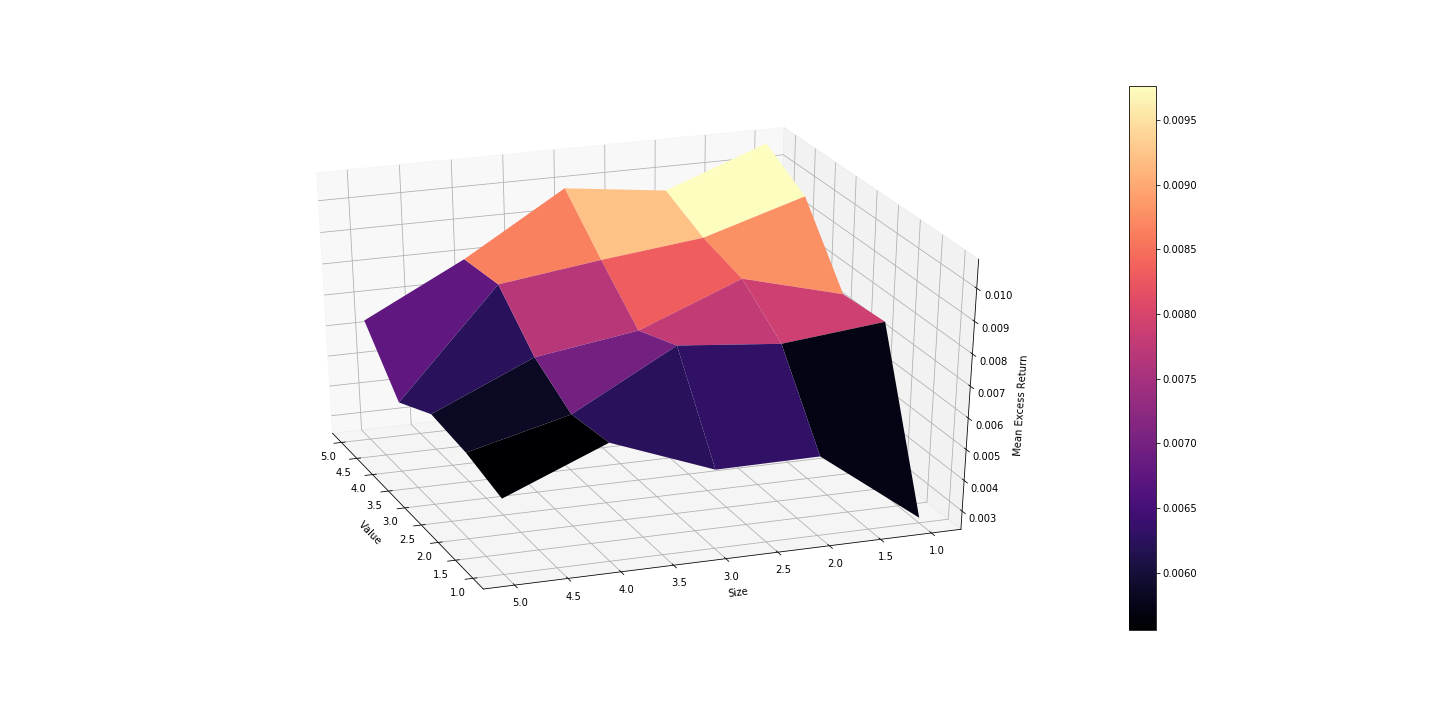

In [67]:
(fig, ax, surf) = surface_plot(mean_rets, cmap='magma')
ax.view_init(30, 160)
fig.colorbar(surf)

ax.set_xlabel('\nValue')
ax.set_ylabel('\nSize')
ax.set_zlabel('\nMean Excess Return')

plt.show()

From the surface plot we observe as the book-to-market (value) ratio increase mean excess return tend to increase, we can conclude portfolios that consist high book-to-market stocks tend to perform better compare to low book-to-market portfolios. On the other hand we observe opposite for the high market cap stocks, we see a increasing trend between low and medium size stocks but when we look at the portfolios that consists high market cap stocks there is a decreasing trend in mean excess return

# Part 2
Run a time-series OLS regression (using the entire sample period) for each portfolio j

$$R_{jt} - R_{ft} = \alpha_j + \beta_j(R_{mt} - R_{ft}) + \epsilon_{jt}$$

Construct a table like the one in question 1, with each cell containing the estimated alpha of each portfolio ($\alpha_j$). Show the table graphically. What does the table suggest about the validity of the CAPM? What portfolios deviate the most from the CAPM predictions? Test the joint significance of pricing errors using the GRS test statistic.

In [68]:
alphas = []
variances = []
betas = []
resids = pd.DataFrame(np.arange(660*25).reshape(-1, 25))
x = df_25_port["r_p"]
x = sm.add_constant(x)
for a in range(len(df_25_port.columns)-1):
    y = df_25_port.iloc[:, a].values
    results = sm.OLS(y, x).fit()
    betas.append(results.params[1])
    alphas.append(results.params[0])
    variances.append(results.scale)
    resids.iloc[:, a] = np.array(results.resid).reshape(-1, 1)

## 5x5 Table of Alphas

In [69]:
betas = np.array(betas)
variances = np.array(variances)
alphas = np.array(alphas).reshape(5, 5)
print("Book-to-Market(Columns), Size(Rows)")
pd.DataFrame(alphas, columns=["v_1", "v_2", "v_3", "v_4", "v_5"], index=[
             "s_1", "s_2", "s_3", "s_4", "s_5"])

Book-to-Market(Columns), Size(Rows)


,v_1,v_2,v_3,v_4,v_5
s_1,-0.004652,0.001528,0.002093,0.004701,0.005288
s_2,-0.002123,0.001510,0.003180,0.003764,0.003826
s_3,-0.001778,0.002116,0.002158,0.003665,0.004516
s_4,-0.000034,0.000550,0.001664,0.003287,0.002462
s_5,-0.000137,0.000448,0.001040,0.000227,0.001464


## 3D Surface Plot of Alphas

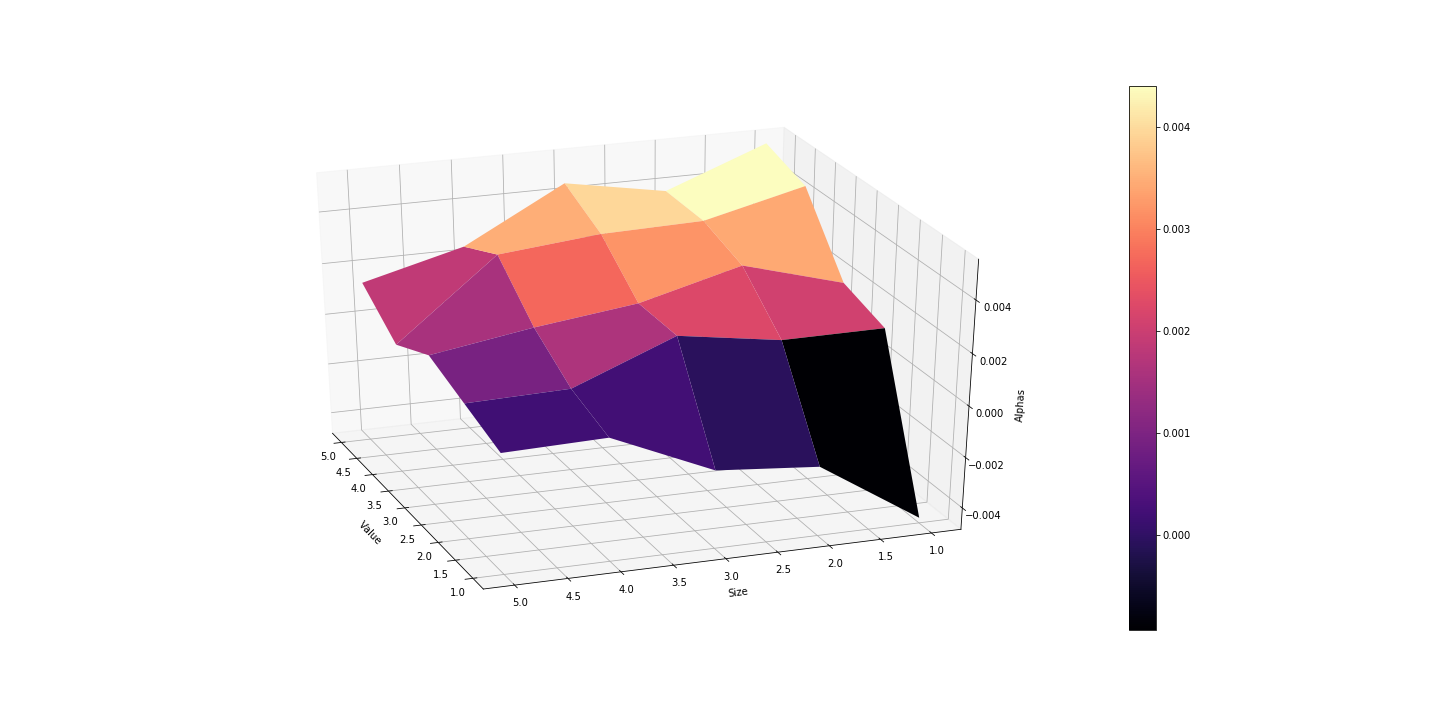

In [70]:
(fig, ax, surf) = surface_plot(alphas, cmap='magma')
ax.view_init(30, 160)
fig.colorbar(surf)

ax.set_xlabel('\nValue')
ax.set_ylabel('\nSize')
ax.set_zlabel('\nAlphas')

plt.show()

## Comments on CAPM and the Alphas

Alphas estimated by OLS time series regression shows that alphas are different than zero. From the surface plot we see that portfolios that formed from small size and high book-to-market ratio stocks have positive alphas. On the other hand portfolios that formed from low book-to-market and small size stocks have negative alphas. Alphas of the large market cap portfolios are around zero. According to CAPM, alphas should be zero but for high value and small size firms, we observe significant positive alphas.

Note that, we stated "According to CAPM, alphas should be zero" but not the Risk Free rate. This is due to we substracted Risk Free rate from portfolio returns before we conducted the regression thus alphas need to be zero for CAPM to hold. This condition applies all the regressions and the tests conducted in this Notebook.

## GRS Statistic Test

In [71]:
t = len(df_25_port)
n = len(df_25_port.columns)-1
df_n = n
df_d = t-n-1
rp_mean = df_25_port["r_p"].mean()
rp_std = df_25_port["r_p"].std()
var_mat = np.array(resids.cov())
alphas_ = alphas.reshape(-1, 1)
robust_var = np.matmul(np.matmul(np.transpose(
    alphas_), np.linalg.inv(var_mat)), alphas_)
grs_crit_ = 1/(1+((rp_mean/rp_std)**2))
grs_crit = ((t-n-1)/n)*grs_crit_*robust_var

In [72]:
grs_p_value = 1-scipy.stats.f.cdf(grs_crit, dfn=25, dfd=634)
print(" GRS_stat:", round(float(grs_crit), 3), "\n P-Value:", round(float(grs_p_value), 15),
      "\n we can reject the hypothesis with a high significance level \n Alphas are def. not 0 ")

 GRS_stat: 4.577 
 P-Value: 3.944e-12 
 we can reject the hypothesis with a high significance level 
 Alphas are def. not 0 


Critical and the P value:


$$GRS_{stat.} = 4.577 \quad \text{and} \quad P_{value} = 3.94351218e-12 < 0.01$$ 

we can reject the joint hypothesis that $$\alpha_j = 0 \quad \forall j$$ 

According to our estimation CAPM is not valid.

# Part 3
Run a single cross-sectional OLS regression of mean excess returns on betas estimated in the previous question:
$$\overline{R_j - R_f} = \gamma_0 + \gamma_1\hat{\beta_j} + \epsilon$$

In [73]:
mean_r_p = df_25_port.drop(["r_p"], axis=1).mean().values.reshape(-1,)
betas = betas.reshape(-1, 1)
betas_reg = sm.add_constant(betas)

## Cross Sectional Regression Summary

In [74]:
csr_reg = sm.OLS(mean_r_p, betas_reg).fit()
print(csr_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.565
Date:                Tue, 05 Nov 2019   Prob (F-statistic):              0.223
Time:                        02:16:44   Log-Likelihood:                 121.29
No. Observations:                  25   AIC:                            -238.6
Df Residuals:                      23   BIC:                            -236.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108      0.003      3.637      0.0

Testing: 
$$H_0: \gamma_1 = \overline{R_m - R_f}$$
$$H_1: \gamma_1 \neq \overline{R_m - R_f}$$

In [75]:
gamma_1_std = csr_reg.bse[1]
gamma_1 = csr_reg.params[1]
h_0_gamma_1 = df_25_port["r_p"].mean()
t_act = np.abs((gamma_1 - h_0_gamma_1)/gamma_1_std)

In [76]:
print("", round(t_act, 2), ">", 2.58,
      "\n We reject H_0: y_1 = R_m - R_f at 99% significance level")
print("\n")
print("", 3.637, ">", 2.58, "\n We reject H_0: y_0 = 0 at 99% significance level")

 3.12 > 2.58 
 We reject H_0: y_1 = R_m - R_f at 99% significance level


 3.637 > 2.58 
 We reject H_0: y_0 = 0 at 99% significance level


Because we regress excess returns to Risk premium we need to obtain 0 for the intercept but from the output of the above regression, we see that:

$$|t_{\gamma_0}| = 3.637 > 2.58 = |t_{crit}|$$ 
thus we reject the hypothesis: 

$$\gamma_0 = 0$$ 
Also, we reject the hypothesis:

$$H_0: \gamma_1 = \overline{R_m - R_f}$$ 
since, 

$$|t_{act}| = 3.12 > 2.58 = |t|$$ 

Both of these hypothesis tests implies CAPM does not hold.


# Part 4

Implement the two-pass approach of Fama-MacBeth. First, estimate each stock’s beta for each month $t$ using a time series regression with 3 years of previous monthly data, i.e., from $t−36$ to $t−1$. Then, run a cross-sectional regression at each time $t$ of excess returns on betas at time $t$. Compute the Fama-MacBeth coefficients and their standard errors. Compare these standard errors with the OLS standard errors from the previous question. Did you expect those differences? Explain why. Test again the CAPM using the Fama-MacBeth estimators and their standard errors.

## First Step

In [77]:
betas_fm = pd.DataFrame(np.arange(15625).reshape(-1, 25))
for a in range(len(df_25_port.columns[:-1])):
    for i in range(len(df_25_port)-35):
        y = df_25_port.iloc[i:i+36, a].values
        x_ = df_25_port.iloc[i:i+36, -1].values.reshape(-1, 1)
        x = sm.add_constant(x_)
        reg = sm.OLS(y, x).fit()
        betas_fm.iloc[i, a] = reg.params[1]

In [78]:
betas_fm_df = pd.DataFrame(betas_fm[:-1].values, index=df_25_port.index[36:], columns=["s1_v1_b", "s1_v2_b", "s1_v3_b", "s1_v4_b", "s1_v5_b",
                                                                                       "s2_v1_b", "s2_v2_b", "s2_v3_b", "s2_v4_b", "s2_v5_b",
                                                                                       "s3_v1_b", "s3_v2_b", "s3_v3_b", "s3_v4_b", "s3_v5_b",
                                                                                       "s4_v1_b", "s4_v2_b", "s4_v3_b", "s4_v4_b", "s4_v5_b",
                                                                                       "s5_v1_b", "s5_v2_b", "s5_v3_b", "s5_v4_b", "s5_v5_b"])

In [79]:
fm_reg_df = pd.concat([df_25_port.iloc[36:, :], betas_fm_df], axis=1)
fm_reg_port = df_25_port.iloc[36:, :].transpose()
fm_reg_betas = betas_fm_df.transpose()

## Second Step

In [80]:
alphas_fm = []
variances_fm = []
betas_fm = []
for a in range(len(fm_reg_port.columns)):
    x_ = fm_reg_betas.iloc[:, a].values.reshape(-1, 1)
    x = sm.add_constant(x_)
    y = fm_reg_port.iloc[:-1, a].values.reshape(-1, )
    results = sm.OLS(y, x).fit()
    betas_fm.append(results.params[1])
    alphas_fm.append(results.params[0])
    variances_fm.append(results.scale)

In [81]:
alphas_fm = pd.DataFrame(np.array(alphas_fm).reshape(
    1, -1), columns=df_25_port.index[36:]).transpose()
betas_fm = pd.DataFrame(np.array(betas_fm).reshape(
    1, -1), columns=df_25_port.index[36:]).transpose()

In [82]:
gamma_0_fm = alphas_fm.mean()
gamma_1_fm = betas_fm.mean()
gamma_0_fm_std = np.sqrt(alphas_fm.var()/len(alphas_fm))
gamma_1_fm_std = np.sqrt(betas_fm.var()/len(betas_fm))

${\large \textbf{Fama-Machbeth Gammas}}$

In [83]:
print("FM - Gamma_0:", round(float(gamma_0_fm), 4))
print("FM - Gamma_1:", round(float(gamma_1_fm), 4))

FM - Gamma_0: 0.0081
FM - Gamma_1: -0.0013


${\large \textbf{Fama-Machbeth Standard Errors}}$

In [84]:
print("FM - Gamma_0 Std. Err.:", round(float(gamma_0_fm_std), 4))
print("FM - Gamma_1 Std. Err.:", round(float(gamma_1_fm_std), 4))

FM - Gamma_0 Std. Err.: 0.0025
FM - Gamma_1 Std. Err.: 0.0028


In [85]:
fm_mean_rp = df_25_port.iloc[36:, -1].mean()
fm_gamma_1_t = np.abs((gamma_1_fm - fm_mean_rp)/gamma_1_fm_std)
fm_gamma_0_t = np.abs((gamma_0_fm)/gamma_0_fm_std)

${\large \textbf{Fama-Machbeth t Statistic}}$

In [86]:
print("FM - Gamma_0 t_stat:", round(float(fm_gamma_0_t), 4))
print("FM - Gamma_1 t_stat:", round(float(fm_gamma_1_t), 4))

FM - Gamma_0 t_stat: 3.2689
FM - Gamma_1 t_stat: 2.3013


## Comments on Fama-Machbeth Std. Errs. and Coefficients

Standard errors measure how preciese the coefficients that are estimated from the sample, meaning how much they vary from sample to sample. When we run the Cross Sectional Regression, we assume 0 Cross Sectional Correlation and homoskedastic errors, in reality this is not true, thus as a result we overestimate or underestimate the standard errors. Instead of running 1 CSR, running a large number of Cross Sectional Regressions allows us to correct for CS correlation and homoskedasticity assumption. Compared to CSR in question(3), the standard error we obtained for $\gamma_0$ is lower but it is higher for $\gamma_1$. This implies $\gamma_0$ tends to vary less between samples while $\gamma_1$ tends to vary more compared to $\gamma_0$. If we check the $t$ statistics for each coefficient both of them implies CAPM does not hold.

For $\gamma_0$, $t_{act} = 3.26 > 2.58$ allows us to reject the hypothesis $\gamma_0 = 0$ at 99% significance level. 

Which implies there are risk factors other than market that affects portfolio returns. 

For $\gamma_1$, $t_{act} = 2.30 > 1.96$ allows us to reject the hypothesis $\gamma_1 = \overline{R_m - R_f}$ at 95% significance level. 

which implies CAPM does not hold.

# Part 5

Repeat question 2 for the FF 3 factor model and the FF 5 factor model, i.e., estimate portfolio alphas from a single time-series regression of portfolio excess returns on the factors, display estimated alphas and plot them. Interpret your results.

In [87]:
del(results)
alphas_3_fact = []
variances_3_fact = []
betas_3_fact = []
alphas_se_3_fact = []
resids_3_fact = pd.DataFrame(np.arange(660*25).reshape(-1, 25))
x = df_3_fact.drop(["RF"], axis=1).values
x = sm.add_constant(x)
for a in range(len(df_25_port.columns)-1):
    y = df_25_port.iloc[:, a].values
    results = sm.OLS(y, x).fit()
    betas_3_fact.append(results.params[1])
    alphas_3_fact.append(results.params[0])
    variances_3_fact.append(results.scale)
    alphas_se_3_fact.append(results.bse[0])
    resids_3_fact.iloc[:, a] = results.resid

## 3-Factor Model Estimated Alphas

In [88]:
betas_3_fact = np.array(betas_3_fact)
variances_3_fact = np.array(variances_3_fact)
alphas_3_fact = np.array(alphas_3_fact).reshape(5, 5)
print("Book-to-Market(Columns), Size(Rows)")
pd.DataFrame(alphas_3_fact, columns=["v_1", "v_2", "v_3", "v_4", "v_5"], index=[
             "s_1", "s_2", "s_3", "s_4", "s_5"])

Book-to-Market(Columns), Size(Rows)


,v_1,v_2,v_3,v_4,v_5
s_1,-0.004976,-0.000109,-0.000328,0.001707,0.001329
s_2,-0.001670,0.000063,0.000762,0.000661,-0.000342
s_3,-0.000829,0.000830,-0.000046,0.000775,0.000684
s_4,0.001199,-0.000444,-0.000254,0.000817,-0.001048
s_5,0.001667,0.000333,0.000091,-0.002159,-0.001718


In [89]:
t = len(df_25_port)
n = len(df_25_port.columns)-1
df_n = n
df_d = t-n-1
rp_mean = df_25_port["r_p"].mean()
rp_std = df_25_port["r_p"].std()
var_mat_3_fact = np.array(resids_3_fact.cov())
alphas_3_fact = alphas_3_fact.reshape(-1, 1)
robust_var_3_fact = np.matmul(np.matmul(np.transpose(
    alphas_3_fact), np.linalg.inv(var_mat_3_fact)), alphas_3_fact)
grs_crit_3 = 1/(1+((rp_mean/rp_std)**2))
grs_crit_3_fact = ((t-n-1)/n)*grs_crit_3*robust_var_3_fact

## GRS Test for 3-Factor Model

In [90]:
grs_3_fact_p_value = 1-scipy.stats.f.cdf(grs_crit_3_fact, dfn=df_n, dfd=df_d)
print(" GRS_stat:", round(float(grs_crit_3_fact), 3), "\n P-Value:", round(float(grs_3_fact_p_value),
                                                                           15), "\n we can reject the hypothesis with a high significance level \n Alphas are def. not 0 ")

 GRS_stat: 3.953 
 P-Value: 7.6681e-10 
 we can reject the hypothesis with a high significance level 
 Alphas are def. not 0 


## 3D Surface Plot for Estimated Alphas of 3-Factor Model

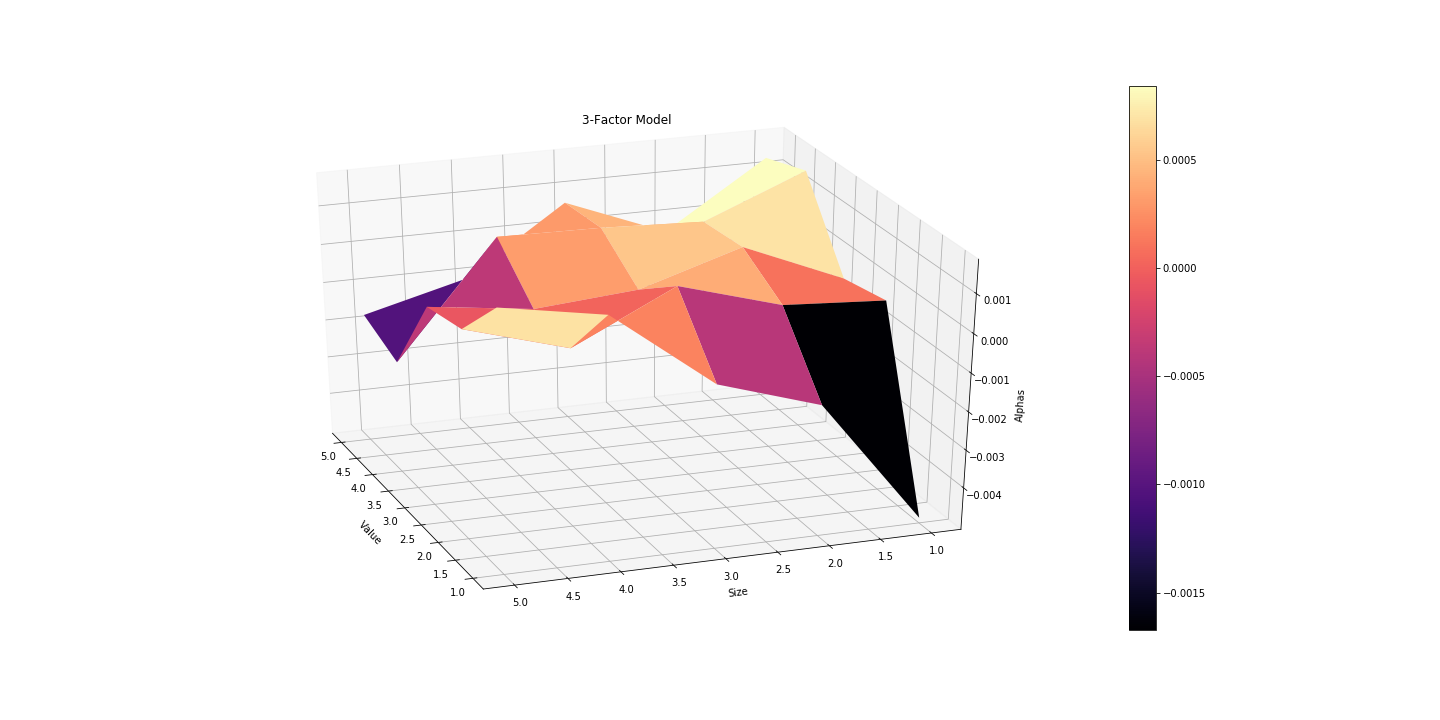

In [91]:
(fig, ax, surf) = surface_plot(alphas_3_fact.reshape(5, 5), cmap='magma')
ax.view_init(30, 160)
fig.colorbar(surf)

ax.set_xlabel('\nValue')
ax.set_ylabel('\nSize')
ax.set_zlabel('\nAlphas')
ax.set_title("3-Factor Model")
plt.show()

## Comments on 3-Factor Model Estimated Alphas

Compared to 1-Factor Model (CAPM), range of the alphas are now more concentrated around zero, which proves market is not the only risk factor that affects portfolio returns. But we still observe alphas that are different than zero (we checked the significance of the alphas but not included in the note-book since the question does not require it).

We can conclude 3-Factor Model does a better job compared to 1-Factor model, but there are still more risk factors that should be included in the model in order to explain portfolio returns to wider extent

## 5-Factor Model

In [92]:
del(results)
alphas_5_fact = []
variances_5_fact = []
betas_5_fact = []
alphas_se_5_fact = []
resids_5_fact = pd.DataFrame(np.arange(660*25).reshape(-1, 25))
x = df_5_fact.drop(["RF"], axis=1).values
x = sm.add_constant(x)
for a in range(len(df_25_port.columns)-1):
    y = df_25_port.iloc[:, a].values
    results = sm.OLS(y, x).fit()
    betas_5_fact.append(results.params[1])
    alphas_5_fact.append(results.params[0])
    variances_5_fact.append(results.scale)
    alphas_se_5_fact.append(results.bse[0])
    resids_5_fact.iloc[:, a] = results.resid

## Alphas Estimated by 5-Factor Model

In [93]:
betas_5_fact = np.array(betas_5_fact)
variances_5_fact = np.array(variances_5_fact)
alphas_5_fact = np.array(alphas_5_fact).reshape(5, 5)
print("Book-to-Market(Columns), Size(Rows)")
pd.DataFrame(alphas_5_fact, columns=["v_1", "v_2", "v_3", "v_4", "v_5"], index=[
             "s_1", "s_2", "s_3", "s_4", "s_5"])

Book-to-Market(Columns), Size(Rows)


,v_1,v_2,v_3,v_4,v_5
s_1,-0.002788,0.001301,-0.000208,0.001849,0.001267
s_2,-0.000739,-0.000236,-0.000003,0.000127,-0.000372
s_3,0.000241,0.000185,-0.000866,-0.000057,-0.000069
s_4,0.001857,-0.001748,-0.001321,0.000376,-0.001180
s_5,0.001155,-0.000847,-0.000745,-0.002499,-0.000149


In [94]:
t = len(df_25_port)
n = len(df_25_port.columns)-1
df_n = n
df_d = t-n-1
rp_mean = df_25_port["r_p"].mean()
rp_std = df_25_port["r_p"].std()
var_mat_5_fact = np.array(resids_5_fact.cov())
alphas_5_fact = alphas_5_fact.reshape(-1, 1)
robust_var_5_fact = np.matmul(np.matmul(np.transpose(
    alphas_5_fact), np.linalg.inv(var_mat_5_fact)), alphas_5_fact)
grs_crit_5 = 1/(1+((rp_mean/rp_std)**2))
grs_crit_5_fact = ((t-n-1)/n)*grs_crit_5*robust_var_5_fact

## GRS Test for 5-Factor Model

In [95]:
grs_5_fact_p_value = 1-scipy.stats.f.cdf(grs_crit_5_fact, dfn=df_n, dfd=df_d)
print(" GRS_stat:", round(float(grs_crit_5_fact), 3), "\n P-Value:", round(float(grs_5_fact_p_value),
                                                                           15), "\n we can reject the hypothesis with a high significance level \n Alphas are def. not 0 ")

 GRS_stat: 3.428 
 P-Value: 5.9025284e-08 
 we can reject the hypothesis with a high significance level 
 Alphas are def. not 0 


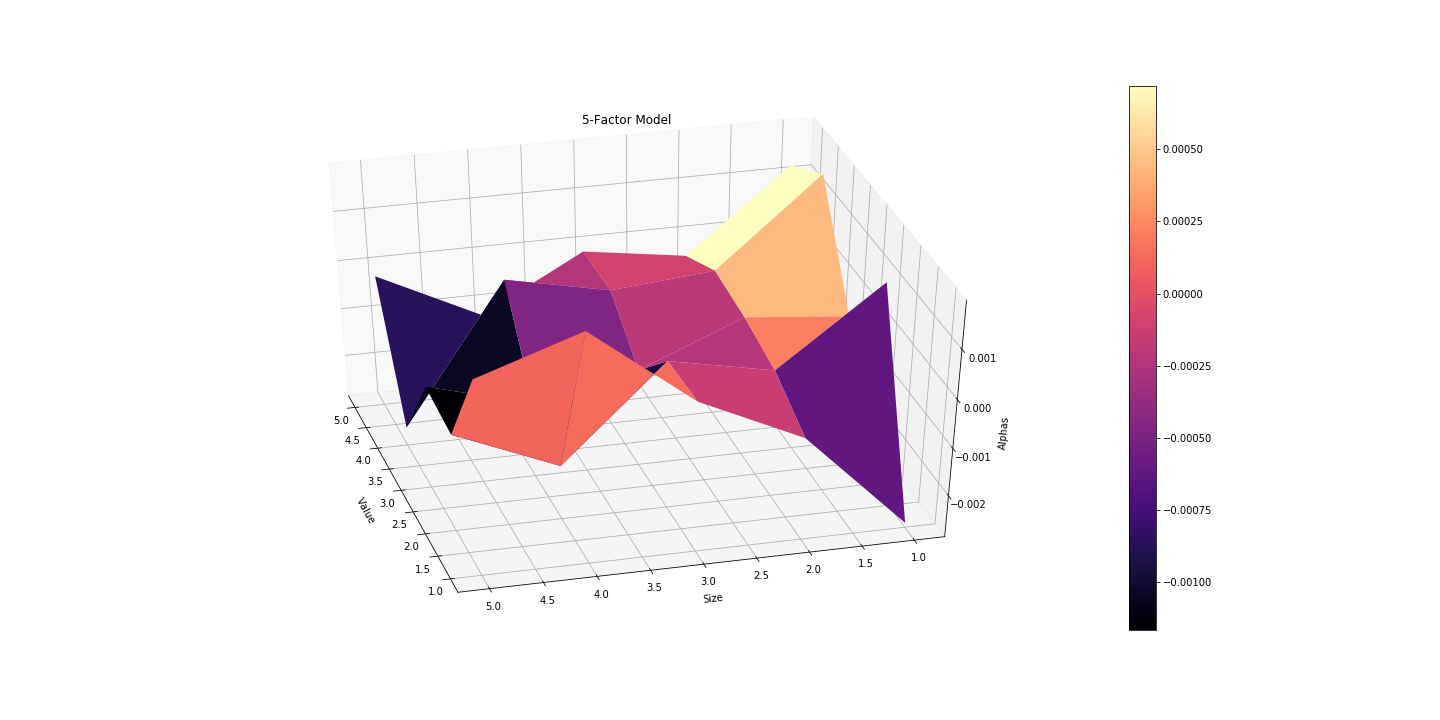

In [96]:
(fig, ax, surf) = surface_plot(alphas_5_fact.reshape(5, 5), cmap='magma')
ax.view_init(40, 165)
fig.colorbar(surf)

ax.set_xlabel('\nValue')
ax.set_ylabel('\nSize')
ax.set_zlabel('\nAlphas')
ax.set_title("5-Factor Model")
plt.show()

## Comments on 5-Factor Model

From the table and the surface plot we observe, alphas are now clustered around zero more compared to 1-Factor and 3-Factor Model. We see that including extra factors help us explain excess returns of the portfolios to even a greater extent compared to 3-Factor model. But plot and the table show that there are still alphas which are different than zero, which means these 5 Factors are not the only risk factors that affects portfolio returns.

To conclude, portfolio returns may be affected by a lot of different factors, and it is a quite hard to include all the possible factors in a certain model. But in any case 3 and the 5 factor models prove that CAPM does not hold and investors are affected by risk factor which are different than market.